In [9]:
# Python 3 notebook for neural network
import numpy as np
import math
import statistics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils import to_categorical
from keras.utils import plot_model
import IPython.display
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

import importlib
import sys
import pickle
import torch
from torch.autograd import Variable
import torch.nn as nn
from random import shuffle
from IPython.core.debugger import Tracer
from keras import regularizers

# https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
we = importlib.import_module("word_embeddings")
import re

In [770]:
""" Global Parameters """
# Load some data
wordEmbedDict = we.getWordEmbeddingDict() # Load the dictionary

# Labels
top_20 = sorted(['AskReddit', 'leagueoflegends', 'nba', 'funny', 'pics', 'nfl', 'pcmasterrace', \
          'videos', 'news', 'todayilearned', 'DestinyTheGame', 'worldnews', 'soccer', \
          'DotA2', 'AdviceAnimals', 'WTF', 'GlobalOffensive', 'hockey', 'movies', 'SquaredCircle'])

# Indices of our desired data
TRUE_LABEL = 8 # Index of the true label, hard coded
BODY_INDEX = 17 # Index of the reddit comment, hard coded

# Neural Network Parameters
NUM_SUBREDDITS = len(top_20)
NUM_FEATURES = 300 # length returned from embedding
NUM_EXAMPLES = 15000 # Arbitrary, choose however many we want to grab from the dataset
NUM_EPOCHS = 13
NUM_HIDDEN_NEURONS = 17
NUM_LAYERS = 1
LEARNING_RATE = 0.001
reg = 0.001

unparsed = "./data/condensed_dataset.pkl" # will change this so we can just call the whole pkl set

# Encoder
encoder = LabelEncoder()
encoder.fit(top_20) # Encodes the NUM_SUBREDDITS subreddits

# Seed
# fix random seed for reproducibility
seed = 8
np.random.seed(seed)
""" """

' '

In [711]:
'''Helper Functions'''

# Normalization of dataset

# Get mean of a column feature
def getMean(column):
    sum = 0
    n = len(column)
    for i in range(n):
        sum += column.iloc[i]
    mean = sum / float(n)
    return mean

def getVariance(column, mean):
    squareMeanSum = 0
    n = len(column)
    for i in range(n):
        squareMeanSum += (column.iloc[i] - mean)**2
    var = math.sqrt(squareMeanSum / float(n))
    return var

def normalizeSet(set):
    numRow = len(set.index)
    numCol = len(set.columns)
    for col in range(numCol):
        column = set.iloc[:,col]
        mean = getMean(column)
        var = getVariance(column, mean)
        
        for row in range(numRow):
            set.iloc[row, col] = float(set.iloc[row, col] - mean) / var
    return set

# @param dir: string, directory of pickle data
# @return dataset: unpickled dataset
def loadPickleData(dir):
    with open(dir, 'rb') as f:
        dataset = pickle.load(f)
    return dataset

# Returns [X, Y] with m examples
def loadData(pickleDir, m):
    pickle = loadPickleData(pickleDir)
    ds = vectorizeDataSet(pickle, m)
    return ds

def stripNonAlpha(word):
    word = re.sub(r'\W+', '', word)
    return word

def vectorizeWord(word):
    word = stripNonAlpha(word)
    keyset = wordEmbedDict.keys() # words in the dictionary
    zeroVec = np.zeros((1, NUM_FEATURES))
    vWord = pd.DataFrame(zeroVec)
    
    if word in keyset:
        vWord = pd.DataFrame(wordEmbedDict[word]).transpose()
    return vWord # returns zero vector if the word is not in the dictionary

def vectorizeComment(body):
#     print(body)
    vComment = np.zeros((1, NUM_FEATURES))
    vComment = pd.DataFrame(vComment)
    words = body.split()
#     print(vComment)
    
    numWords = 0
    for word in words:
        vWord = vectorizeWord(word)
        numWords += 1
        vComment = vComment + vWord
    vComNP = vComment.values
    vComScaled = vComNP * (1/float(numWords))
    vComScaled = pd.DataFrame(vComScaled)
    return vComScaled

# Encodes a subreddit string into an unrolled one-hot pandas vector
def oneHotEncode(subreddit):
    #   https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
    encoded_Y = encoder.transform([subreddit])[0] # get the integer category
    
    oneHot = [0 for _ in range(NUM_SUBREDDITS)]
    oneHot[encoded_Y] = 1
    pandasOneHot = pd.DataFrame(oneHot)
    
    return pandasOneHot.transpose()
    
# Returns a squished array from 3D data 
# entries are examples, not comments (body)
def to2D(data):
    data_2D = []
    for i in range(len(data)):
        sub_collection = data[i] 
        for example in sub_collection:
            data_2D.append(example)
    df = pd.DataFrame(data_2D)
#     print(df.shape)
#     df.tail()
    return df
    
    
#TODO: check if seed is bad?? just set a new random seed
#TODO: limit number of features 
def vectorizeDataSet(data, m):
#     Tracer()()
#     print(len(data))
#     data = pd.DataFrame(data)
#     data = data.sample(frac=1, random_state=88).reset_index(drop=True) # Shuffles data
#     print("shape at vectorize data set: ", data.shape)
    
    data_2D = to2D(data)
    data_2D = data_2D.sample(frac=1)
#     print(data_2D.iloc[:3, :])
    
    comments = data_2D.pop(BODY_INDEX)
#     print(len(comments))
    true_labels = data_2D.pop(TRUE_LABEL)
    
    unrollComment = comments[0]
#     print("unrollcomment: \n", unrollComment)
#     print(type(unrollComment))
    X = vectorizeComment(unrollComment)
#     print(X)
    firstSubreddit = true_labels[0]
    Y = oneHotEncode(firstSubreddit)
#     print('length of comments: ', len(comments))
    
#     print("comments[i]: ", comments[1])

    # For each example in old data set, get the actual comment and featurize it into X
    # Also get unrolled true label
    for i in range(1, m):
        comment = comments[i]
        example = vectorizeComment(comment)
        subreddit = true_labels[i]
        oneHot = oneHotEncode(subreddit)
        
        X = pd.concat([X, example])
        Y = pd.concat([Y, oneHot])
        
    X_scaled = preprocessing.StandardScaler().fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled)
    X_scaled_df.reset_index(drop=True, inplace=True)
    Y.reset_index(drop=True, inplace=True)
    concat = pd.concat([X_scaled_df, Y], axis=1)
    return concat



In [359]:
# # Debugging
# data = loadPickleData(unparsed)
# print(data[0][0])

In [360]:
# # Debugging
# # print(data[2][0])
# print(len(data[0]))

# # print(len(data))

# # print(len(data[1][1]))

# data_2D = to2D(data)
# print(len(data_2D))
# # comments = data_2D.pop(BODY_INDEX)

# # print(len(comments))
# # # print(data_2D[0])
# # df = pd.DataFrame(data_2D)
# # # df.tail()
# # comments = df.pop(BODY_INDEX)
# print(len(comments))

In [451]:
# Split dataset
#https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213
def train_validate_test_split(df, train_percent=.8, validate_percent=.1, seed=None):
    m = len(df.index)
    
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[:train_end]
    validate = df.iloc[train_end:validate_end]
    test = df.loc[validate_end:]
    return train, validate, test

In [348]:
%%time
df = loadData(unparsed, NUM_EXAMPLES)

CPU times: user 8min 31s, sys: 5min 6s, total: 13min 37s
Wall time: 13min 39s


In [452]:
train, validate, test = train_validate_test_split(df)


train_labels = train.iloc[:, NUM_FEATURES:]
validate_labels = validate.iloc[:, NUM_FEATURES:]
test_labels = test.iloc[:, NUM_FEATURES:]

train = train.iloc[:, :NUM_FEATURES]
validate = validate.iloc[:, :NUM_FEATURES]
test = test.iloc[:, :NUM_FEATURES]

train_labels.tail()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
11995,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
11997,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11998,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
11999,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [453]:
# %%time
# # # Save the dataframe as a pickle file to be read later
# # df.to_pickle("./data/pandas-pickle-small.pkl")

# # check if potentially overwriting data with the same feature everytime
# unpickled = pd.read_pickle("./data/pandas-pickle-small.pkl")
# unpickled.tail()

In [771]:
%%time
# Check softmax output (final layer output)
# Check gradients inside the keras model built in function
# Neural network function
def build_nn(hidden_layer_sizes):
    model = keras.Sequential()
    
    # Input layer
    model.add(layers.Dense(hidden_layer_sizes[0], input_dim=NUM_FEATURES, activation='relu', use_bias=True, activity_regularizer=regularizers.l2(reg)))

    for size in hidden_layer_sizes[1:]:
        model.add(layers.Dense(size, activation='relu', use_bias=True, activity_regularizer=regularizers.l2(reg)))
        model.add(layers.Dropout(0.25))
    # Output layer
    model.add(layers.Dense(NUM_SUBREDDITS, activation='softmax'))
    
    # Optimizer. Can change this to whatever we want
    optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc','categorical_crossentropy'])
    return model

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 23.4 µs


In [772]:
%%time
# Build the model
# Features might be an issue, pick different subreddits
# potentially try out CNN with matrix word embedding without combined word embedding
sizes_list = [NUM_HIDDEN_NEURONS for i in range(NUM_LAYERS)]
nn_model = build_nn(sizes_list)
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_335 (Dense)            (None, 17)                5117      
_________________________________________________________________
dense_336 (Dense)            (None, 20)                360       
Total params: 5,477
Trainable params: 5,477
Non-trainable params: 0
_________________________________________________________________
CPU times: user 250 ms, sys: 15.6 ms, total: 266 ms
Wall time: 210 ms


In [773]:
%%time
# Get neural network history
# Change batch size (inspect what happens with each ITERATION, not EPOCH)
# History is the progress of our neural network, will be used to plot cost functions
nn_history = nn_model.fit(train, train_labels, epochs=NUM_EPOCHS, verbose=1,
         validation_data=(validate, validate_labels))

Train on 12000 samples, validate on 1500 samples
Epoch 1/13
12000/12000 [==============================] - 5s 411us/sample - loss: 2.9446 - acc: 0.1163 - categorical_crossentropy: 2.9318 - val_loss: 2.7403 - val_acc: 0.1693 - val_categorical_crossentropy: 2.7247
Epoch 2/13
12000/12000 [==============================] - 2s 143us/sample - loss: 2.6107 - acc: 0.2037 - categorical_crossentropy: 2.5910 - val_loss: 2.6152 - val_acc: 0.2093 - val_categorical_crossentropy: 2.5938
Epoch 3/13
12000/12000 [==============================] - 2s 144us/sample - loss: 2.4847 - acc: 0.2461 - categorical_crossentropy: 2.4605 - val_loss: 2.5710 - val_acc: 0.2227 - val_categorical_crossentropy: 2.5458
Epoch 4/13
12000/12000 [==============================] - 2s 144us/sample - loss: 2.4096 - acc: 0.2632 - categorical_crossentropy: 2.3830 - val_loss: 2.5429 - val_acc: 0.2467 - val_categorical_crossentropy: 2.5160
Epoch 5/13
12000/12000 [==============================] - 2s 144us/sample - loss: 2.3591 - acc:

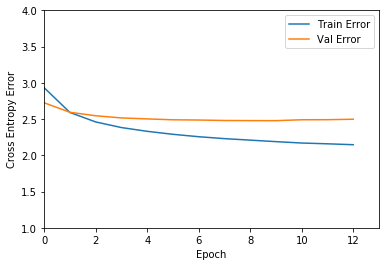

In [774]:
# Plot metrics
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy Error')
    plt.plot(hist['epoch'], hist['categorical_crossentropy'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_categorical_crossentropy'],
           label = 'Val Error')
    plt.xlim([0,NUM_EPOCHS])
    plt.ylim([1,4])
    plt.legend()
    plt.show()
    
plot_history(nn_history)

In [775]:
# Expects list
def accuracy(predictions, true_label):
    count = 0
    total = len(predictions)
    for i in range(total):
        if (predictions[i] == true_label[i]):
            count += 1
    print("Test accuracy is: {}%".format(100 *float(count) / total))
    
# Test accuracy:

###
# transforms one hot matrix back into a vector of classes
def toClasses(oneHotMatrix):
    oneHotNPArray = oneHotMatrix.values
    classes = []
    
    num_ex = np.size(oneHotNPArray, 0)
    
    for i in range(num_ex):
        row = oneHotNPArray[i]
        sub_num = np.argmax(row)
        classes = np.append(classes, sub_num)
    return classes
###




# print(y_classes)


# print(y_classes)
# print(test_labels)

In [776]:
# See Accuracy
y_prob = nn_model.predict(test)

# print(y_prob)
y_hat_classes = y_prob.argmax(axis=-1)
test_classes = toClasses(test_labels)
# print((y_hat_classes))
# # print((test_classes))

accuracy(y_hat_classes, test_classes)


hist = pd.DataFrame(nn_history.history)
train_acc_vec = hist.pop("acc")
val_acc_vec = hist.pop("val_acc")
finalTrainAcc = train_acc_vec[len(train_acc_vec) - 1]
finalValAcc = val_acc_vec[len(val_acc_vec) - 1]
print("Final training accuracy: {}%".format(finalTrainAcc*100))
print("Final validation accuracy: {}%".format(finalValAcc*100))


Test accuracy is: 28.4%
Final training accuracy: 33.19166600704193%
Final validation accuracy: 26.733332872390747%


Confusion matrix, without normalization
[[ 4  6  1  2  2  2 10  5  3  3  5  0 13  1  2  1  0  5  3  4]
 [ 3 18  2  1  3  7 13  2  3  0  3  0  6  1  2  2  1  4  2  1]
 [ 0  4 32  9  7  3  4  1  2  5  1  1  2  1  9  0  0  0  3  1]
 [ 1  2  6 18  8  3  1  2  2 10  0  7  0  1  8  1  2  0  0  2]
 [ 4  2  6  4 18  3  3  5  2  9  1  1  0  3 10  1  3  0  3  2]
 [ 0  0  4  0  0 28  4  1  3  3  5  1  1  3  3  1  1  2  2  1]
 [ 4  8  0  0  3  3 18  3  3  1  2  1  2  1  2  3  1  7  7  8]
 [ 2  3  2  1  3  5  7  5  6  3  5  1  2  0  1  5  2  3  5  6]
 [ 1  2  0  2  1  6  0  1 18  2  1  5  0  7  1  3  8  0  1  3]
 [ 0  2  5  8  4  2  0  2  2 26  2  3  0  2  3  1  3  0  4  0]
 [ 1  1  2  1  0  7  4  4  5  1 41  1  1  1  3  3  0  2  5  2]
 [ 0  2  2  2  3 10  0  1 11  4  0 19  1 11  2  0  6  1  2  1]
 [ 2  4  2  1  0  0  8  2  3  2  4  0 34  2  3  5  1  6  2  8]
 [ 0  1  5  2  0  3  3  1  9  3  3  3  2 39  2  3  3  0  4  2]
 [ 2  1  2  4  2  6  3  5  2  3  2  2  1  0 23  1  1  2  1  1]
 [ 2  4  0  2  

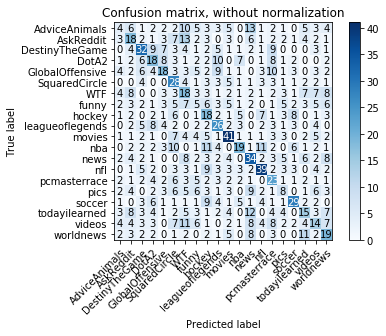

In [777]:
# Plot confusion matrix

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    
    plt.figure(figsize=(50,50))
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.show()
    fig.tight_layout()
    return ax
plot_confusion_matrix(test_classes, y_hat_classes, top_20)

In [ ]:
%%time
# Logistic Regression Model
df2 = pd.read_pickle("./data/pandas-pickle-small.pkl")
df2 = df2.sample(frac=1, random_state=2).reset_index(drop=True) # Shuffles data
# # print("This is our X: ", df2.iloc[:, ]
numTrain = 9000
numTest = 1000

X = df2.iloc[0:numTrain, :NUM_FEATURES]
X_array = X.values

y = df2.iloc[0:numTrain, NUM_FEATURES:]
y_array = y.values

y_array_rows = y_array.shape[0]

y_integer_classes = np.array([])
for i in range(y_array_rows):
    row = y_array[i]
    index = np.where(row==1)[0][0]
    y_integer_classes = np.append(y_integer_classes, int(index))

testX = df2.iloc[numTrain:numTrain+numTest, :NUM_FEATURES]
testX_array = testX.values
testY = df2.iloc[numTrain:numTrain+numTest, NUM_FEATURES:]
testY_array = testY.values

testy_array_rows = testY_array.shape[0]
testy_integer_classes = np.array([])
for i in range(testy_array_rows):
    row = testY_array[i]
    index = np.where(row==1)[0][0]
    testy_integer_classes = np.append(testy_integer_classes, int(index))

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
n_estimators = 10
print("Prediction results: \n")
predictions = OneVsRestClassifier(BaggingClassifier(LinearSVC(random_state=0, max_iter=1000), n_estimators = n_estimators)).fit(X_array, y_integer_classes).predict(testX_array)
print(predictions)
print("True results: \n")
print(testy_integer_classes)


# Expects list
def accuracy(predictions, true_label):
    count = 0
    total = len(predictions)
    for i in range(total):
        if predictions[i] == true_label[i]:
            count += 1
    return float(count) / total

pred_list = predictions.tolist()
testy_list = testy_integer_classes.tolist()
print("SVM accuracy: {}%".format(accuracy(pred_list, testy_list)*100))
        